In [4]:
#Importing essential libraries
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os 
import cv2
import random 
import math
import imblearn

from datetime import datetime

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras

In [2]:
df1 = pd.read_csv('C:/Users/Rathi/ml/cic-ids/cic_ids2017_botnet.csv')
df2 = pd.read_csv('C:/Users/Rathi/ml/cic-ids/cic_ids2017_brute_force.csv')
df3 = pd.read_csv('C:/Users/Rathi/ml/cic-ids/cic_ids2017_ddos.csv')
df4 = pd.read_csv('C:/Users/Rathi/ml/cic-ids/cic_ids2017_dos_ddos.csv')
df5 = pd.read_csv('C:/Users/Rathi/ml/cic-ids/cic_ids2017_infilteration.csv')
df6 = pd.read_csv('C:/Users/Rathi/ml/cic-ids/cic_ids2017_port_scan.csv')
df7 = pd.read_csv('C:/Users/Rathi/ml/cic-ids/cic_ids2017_web_attacks.csv')

In [3]:
#Grouping the similar labels 
df2['label']= df2['label'].replace(["FTP-BruteForce","SSH-Bruteforce"],"BruteForce")
df4['label']= df4['label'].replace(["DoS attacks-Hulk","DoS attacks-GoldenEye","DoS attacks-Slowloris","DoS attacks-SlowHTTPTest","Heartbleed"],"DoS")
df7['label']= df7['label'].replace(["Brute Force -Web","Brute Force -XSS","SQL Injection"],"WebAttack")


In [4]:
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7

In [5]:
#Dropping timestamp column
df=df.drop(columns=['timestamp'])

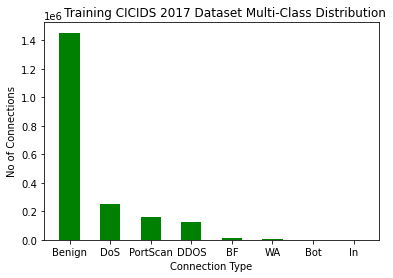

In [14]:

x_axis=['Benign','DoS','PortScan','DDOS','BF','WA','Bot','In']
y_axis= [1454613,252672,158930,128027,13835,2180,1966,36]

average = dict(zip(x_axis, y_axis))

plt.bar(list(average.keys()),average.values(),width =0.5 , color='green')
plt.xlabel('Connection Type')
plt.ylabel('No of Connections')
plt.title('       Training CICIDS 2017 Dataset Multi-Class Distribution')
plt.show()

In [7]:
# drop one variable features 
one_variable_list = []
for i in df.columns:
    if df[i].value_counts().nunique() < 2:
        one_variable_list.append(i)
df.drop(one_variable_list,axis=1,inplace=True)
df.columns =  df.columns.str.strip()

In [8]:
df.shape

(2012223, 69)

In [9]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [10]:
df.shape

(2010000, 69)

In [11]:
df =  df.drop_duplicates(keep="first")
df.reset_index(drop=True,inplace=True)

In [12]:
df.shape

(1778438, 69)

In [13]:
data = df.copy()

In [14]:
data['label'].unique()

array(['Benign', 'Bot', 'BruteForce', 'DDOS LOIT', 'DoS', 'PortScan',
       'WebAttack'], dtype=object)

In [15]:
df['label'].unique()

array(['Benign', 'Bot', 'BruteForce', 'DDOS LOIT', 'DoS', 'PortScan',
       'WebAttack'], dtype=object)

In [16]:
for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
            
            

attackType = data['label'].unique()
data['label'] = data['label'].astype('category')
data['label'] = data['label'].astype("category").cat.codes

In [17]:
data['label'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

In [18]:
data['label']=data['label'].replace([1,2,3,4,5,6],+1)

In [19]:
data['label'].value_counts()

0    1352733
1     425705
Name: label, dtype: int64

In [20]:
y = data['label'].copy()
X = data.drop(['label'],axis=1)

In [21]:
print('X ',X.shape)
print('y ',y.shape)

X  (1778438, 68)
y  (1778438,)


In [22]:
digit_train, counts_train = np.unique(y, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 1352733, 1: 425705}


#### Balancing The Imbalanced Data

In [23]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler('majority')
X_rus, y_rus = rus.fit_sample(X, y)

c:\users\rathi\appdata\local\programs\python\python38\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [24]:
print('X_rus ',X_rus.shape)
print('y_rus ',y_rus.shape)

X_rus  (851410, 68)
y_rus  (851410,)


In [25]:
digit_train, counts_train = np.unique(y_rus, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 425705, 1: 425705}


In [26]:
y_rus.value_counts()

1    425705
0    425705
Name: label, dtype: int64

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = X.select_dtypes(include=['float32','float16','int32','int16','int8']).columns
train_X = scaler.fit_transform(X.select_dtypes(include=['float32','float16','int32','int16','int8']))

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X_rus,y_rus,train_size=0.70, random_state=2)

In [29]:
print('X_train :',X_train.shape)
print('Y_train :',Y_train.shape)
print('X_test  :',X_test.shape)
print('Y_test  :',Y_test.shape)

X_train : (595987, 68)
Y_train : (595987,)
X_test  : (255423, 68)
Y_test  : (255423,)


In [30]:
digit_train, counts_train = np.unique(Y_train, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 297934, 1: 298053}


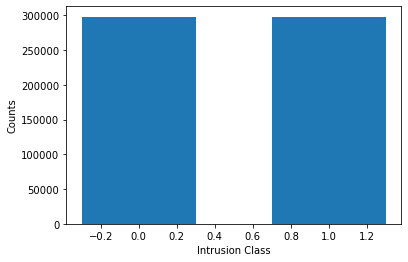

In [31]:
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.6)
plt.xlabel('Intrusion Class')
plt.ylabel('Counts')
plt.show()

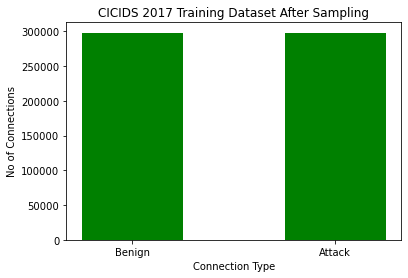

Benign Count: 297934
Attack Count: 298053


In [19]:
x_axis=['Benign','Attack']
y_axis= [297934 ,298053]

average = dict(zip(x_axis, y_axis))

plt.bar(list(average.keys()),average.values(),width =0.5 , color='green')
plt.xlabel('Connection Type')
plt.ylabel('No of Connections')
plt.title('CICIDS 2017 Training Dataset After Sampling')
plt.show()
print('Benign Count: 297934') 
print('Attack Count: 298053')

In [32]:
digit_train, counts_train = np.unique(Y_test, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 127771, 1: 127652}


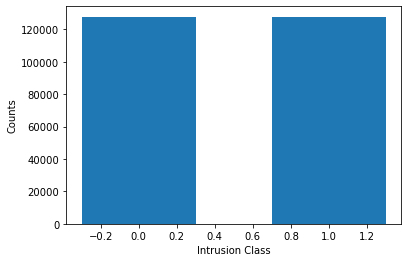

In [33]:
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.6)
plt.xlabel('Intrusion Class')
plt.ylabel('Counts')
plt.show()

In [34]:
import pickle

pickle_out = open("X_train_rusb.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("y_train_rusb.pickle","wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()

In [35]:
pickle_out = open("X_test_rusb.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("y_test_rusb.pickle","wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()